In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet

from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('data/daily_min_temp.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df['unique_id'] = 0
df = df.rename(columns={"Date": "ds", "Temp": "y"})

df = df[['unique_id', 'ds', 'y']]

df.head()

,unique_id,ds,y
0,0,1981-01-01,20.7
1,0,1981-01-02,17.9
2,0,1981-01-03,18.8
3,0,1981-01-04,14.6
4,0,1981-01-05,15.8


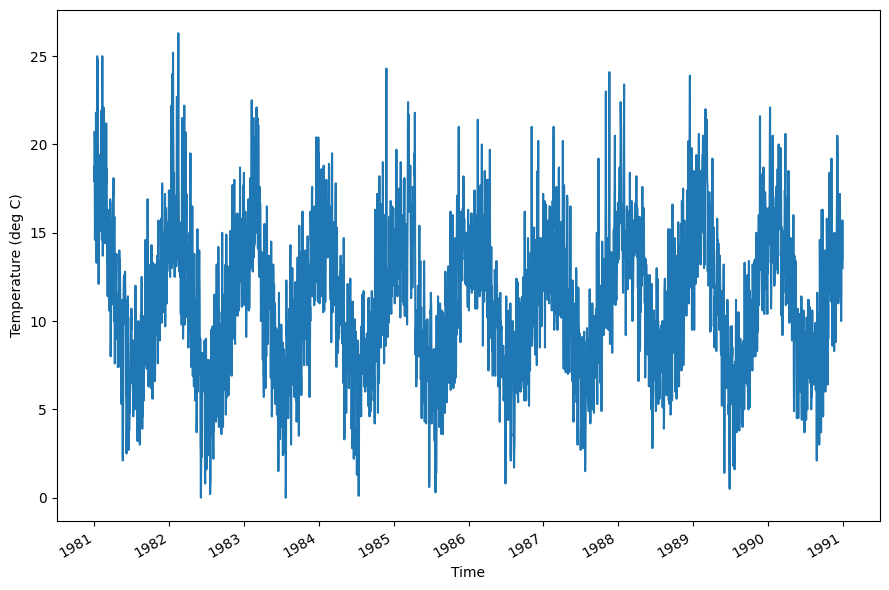

In [4]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 

In [5]:
horizon = 365

models = [NHITS(h=horizon,
               input_size=horizon,
               max_steps=10),
         NBEATS(h=horizon,
               input_size=horizon,
               max_steps=10),
         TimesNet(h=horizon,
                 input_size=horizon,
                 max_steps=10)]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [6]:
nf = NeuralForecast(models=models, freq='D')

In [9]:
preds_df = nf.cross_validation(df=df[-731:], step_size=horizon, n_windows=1)

Epoch 9: 100%|█████████████████| 1/1 [00:00<00:00,  7.14it/s, v_num=28, train_loss_step=0.727, train_loss_epoch=0.0573]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████████████| 1/1 [00:00<00:00,  6.85it/s, v_num=30, train_loss_step=4.620, train_loss_epoch=8.440]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████| 1/1 [05:48<00:00, 348.61s/it, v_num=32, train_loss_step=0.0972, train_loss_epoch=0.0733]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


In [10]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,TimesNet,y
0,0,1990-01-01,1989-12-31,11.793491,8.607419,12.536865,14.8
1,0,1990-01-02,1989-12-31,12.129256,6.997339,15.154198,13.3
2,0,1990-01-03,1989-12-31,11.638921,9.680237,12.507437,15.6
3,0,1990-01-04,1989-12-31,12.396671,8.612388,7.581656,14.5
4,0,1990-01-05,1989-12-31,12.661303,9.428107,12.802521,14.3


## Evaluation 

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(preds_df['ds'], preds_df['y'], label='Actual')
ax.plot(preds_df['ds'], preds_df['NHITS'], label='NHITS', ls='--', color='red')
ax.plot(preds_df['ds'], preds_df['NBEATS'], label='NBEATS', ls=':', color='green')
ax.plot(preds_df['ds'], preds_df['TimesNet'], label='TimesNet', ls='-.', color='black')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,3.322150,3.915893,3.863968
mse,16.047573,23.962759,21.626941
